#### This requires pre-processed data: analysis_16mms.pkl, whick can be generated from raw data by running saw_16_mms.ipynb.

In [6]:
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.special import jv, ive
import os
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import least_squares
from mossbauer_analysis.mossbauer_theory import CobaltRhodium, CobaltFe, KFeCy, alphaFe, Mossbauer    #import classes for sources, absorbers, and the mossbauer transmission spectrum


In [7]:
plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 7,
    "axes.labelsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "figure.titlesize": 7,
    "lines.linewidth": 0.5,
    "lines.markersize": 1,
    "legend.frameon": False
})


In [8]:
def poly5(p,x):
    """5th order polynomial"""
    return p[0] +p[1]*x + p[2]*x**2 + p[3]*x**3 + p[4]*x**4 + p[5]*x**5

def poly1(p,x):
    return p[0] +p[1]*x 

def lorentzian18poly5(p, x):

    #fullwidth = 0.21
    c0, c1, c2, c3, c4, c5, c6, c7, c8, x0, x1, x2, x3, x4, x5, x6, x7,x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, fullwidth, offset, slope, p2, p3, p4, p5 = p
    
    constrasts = [c0, c1, c2, c3, c4, c5, c6, c7, c8, c8, c7, c6, c5, c4, c3, c2, c1, c0]
    resonances = [x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17]
    peaks = np.zeros_like(x, dtype=float)

    for c_i, x_i in zip(constrasts, resonances):
        peaks += -c_i*(fullwidth/2)**2 / ((x - x_i)**2 + (fullwidth/2)**2)
    
    return offset + slope*x + p2*x**2 + p3*x**3 + p4*x**4+ p5*x**5+ peaks


def solve_wls_system(A, y, dy):
    """
    Perform a weighted least squares fit with uncertainty propagation.

    Parameters:
        A  : np.ndarray  — design matrix (N×M)
        y  : np.ndarray  — measured data (N,)
        dy : np.ndarray  — uncertainties on y (N,)

    Returns:
        x  : np.ndarray  — best-fit parameters (M,)
        dx : np.ndarray  — 1σ uncertainties on parameters (M,)
        y_fit : np.ndarray — best-fit values of y
        dy_fit : np.ndarray — propagated 1σ uncertainty on y_fit
    """
    # Normalize A and y 
    Aw = A / dy[:, None]
    yw = y / dy

    # Solve least squares
    x = np.linalg.lstsq(Aw, yw, rcond=None)[0]

    # Residuals and reduced chi²
    residuals = y - A @ x
    norm_residuals = residuals / dy
    dof = len(y) - len(x)
    reduced_chi2 = np.sum(norm_residuals**2) / dof

    # Covariance matrix and uncertainties
    cov_x = np.linalg.inv(Aw.T @ Aw) * reduced_chi2
    dx = np.sqrt(np.diag(cov_x))

    # Propagate uncertainties to fitted y
    y_fit = A @ x
    dy_fit = np.sqrt(np.sum((A @ cov_x) * A, axis=1))

    return x, dx, y_fit, dy_fit

def gaussian_pdf_scalar(y, y0, epsilon):
    norm = 1 / (np.sqrt(2 * np.pi) * epsilon)
    exponent = -0.5 * ((y - y0) / epsilon) ** 2
    return norm * np.exp(exponent)

def arcsine_pdf_scalar(y, y0, epsilon):
    arg = (y - y0) / epsilon
    if np.abs(arg) >= 1:
        return 0.0
    return 1 / (np.pi * np.sqrt(1 - arg**2)) / epsilon

def sqrt_pdf_scalar(y, y0, epsilon):
    z = y**2
    arg = z - y0 - epsilon**2
    if y <= 0 or np.abs(arg) > 2 * epsilon:
        return 0.0
    denom = np.sqrt(4 * epsilon**2 - arg**2)
    return (2 * y) / (np.pi * denom)



def integrand_n(y, y0, epsilon, A, n):
    return sqrt_pdf_scalar(y, y0, epsilon)*jv(n,A*y)**2
    

def model_all_orders(x, m, epsilon, y0=1.0):
    a = y0 - 3*epsilon
    b = y0 + 3*epsilon

    y0 = y0
    
    A = m * x
    
    p0 = quad(integrand_n, a, b, args=(y0, epsilon, A, 0))[0]
    p1 = quad(integrand_n, a, b, args=(y0, epsilon, A, 1))[0]
    p2 = quad(integrand_n, a, b, args=(y0, epsilon, A, 2))[0]
    
    return np.array([p0,p1,p2])

def residuals(params, xdata, ydata, yerr):
    m, epsilon = params
    res = []
    for i in range(len(xdata)):
        model_vals = model_all_orders(xdata[i], m, epsilon)
        diff = (model_vals - ydata[:, i]) / yerr[:, i]
        res.extend(diff)
    return np.array(res)



In [9]:
results_df = pd.read_pickle('analysis_16mms.pkl')
fitfunction = lorentzian18poly5
savedir = 'C:\\Users\\magrini\\Dropbox\\0 - stanford\\paper_saw\\figures\\'

## Main
### FIGURE 3A


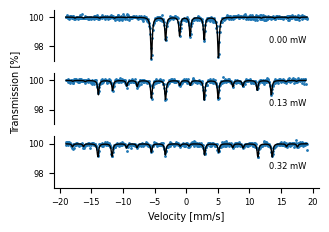

In [10]:
plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 7,
    "axes.labelsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "figure.titlesize": 7,
    "lines.linewidth": 1,
    "lines.markersize": 2,
    "legend.frameon": False
})

side = 'left'
powers_to_plot = [-100, -9, -5]
#powers_to_plot = [-3, -7, -9, -100]
n = len(powers_to_plot)

def mms_to_mhz(x):
    return x * 3.28084

def mhz_to_mms(x):
    return x / 3.28084

fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(8/2.54, 6/2.54), sharex=True)


df_single = results_df[(results_df['side'] == side) & (results_df['power'] == -7)]
cal = df_single['calibration_fit'].values[0]


for i, (power, ax) in enumerate(zip(powers_to_plot, axes)):
    df_single = results_df[(results_df['side'] == side) & (results_df['power'] == power)]
    if df_single.empty:
        continue

    
    bgparams = df_single['bg_params'].values[0]
    fitparams = df_single['fitparams'].values[0]

    x = df_single['x'].values[0]
   
    x_real = poly1([-cal[0]/cal[1], 1/cal[1]], x)

    y = df_single['y'].values[0]
    y_norm = y / poly5(bgparams, x) * 100
    y_fit_norm = lorentzian18poly5(fitparams, x) / poly5(bgparams, x) * 100

    ax.plot(x_real, y_norm, '.', markersize=2)
    ax.plot(x_real, y_fit_norm, '-', color='black', linewidth=1)

    integral_bw = 0.5
    cal = df_single['calibration_fit'].values[0]
   
    ax.set_ylim(97, 100.5)

    # Minimal power label
    ax.text(0.95, 0.5, f"{10**(power/10):.2f} mW", transform=ax.transAxes,
            ha='right', va='top', fontsize = 6)

    # Hide ticks and spines except for bottom
    if i < n - 1:
        ax.tick_params(labelbottom=False,bottom=False, left=True)
        ax.spines['bottom'].set_visible(False)
    else:
        ax.set_xlabel("Velocity [mm/s]")
        #ax.spines['bottom'].set_position(('outward', 40))

    ax.set_yticks([98, 100])
    # Clean top/right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.subplots_adjust(left=0.1, bottom=0.08, right=0.98, top=0.98, hspace=0)
fig.text(-0.02, 0.6, 'Transmission [%]', va='center', rotation='vertical', fontsize = 7)


plt.tight_layout()
#plt.savefig(savedir+"normalized_spectra_main.png", dpi=300, bbox_inches='tight')
plt.show()

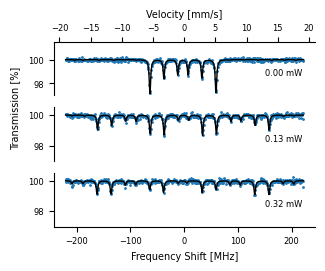

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 7,
    "axes.labelsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "figure.titlesize": 7,
    "lines.linewidth": 1,
    "lines.markersize": 2,
    "legend.frameon": False
})

# === Constants and conversion functions ===
E_0 = 14.4e3 * 1.602e-19      # 14.4 keV in J
h = 6.626e-34                 # Planck's constant
c = 3.0e8                     # speed of light
factor = E_0 / (h * c) / 1e6 * 1e-3  # MHz per mm/s

mms_to_mhz = lambda v: factor * v
mhz_to_mms = lambda f: f / factor

# === Settings ===
side = 'left'
powers_to_plot = [-100, -9, -5]
n = len(powers_to_plot)

fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(7.9/2.54, 7/2.54), sharex=True)

df_single = results_df[(results_df['side'] == side) & (results_df['power'] == -7)]
cal = df_single['calibration_fit'].values[0]

for i, (power, ax) in enumerate(zip(powers_to_plot, axes)):
    df_single = results_df[(results_df['side'] == side) & (results_df['power'] == power)]
    if df_single.empty:
        continue

    bgparams = df_single['bg_params'].values[0]
    fitparams = df_single['fitparams'].values[0]

    x = df_single['x'].values[0]
    y = df_single['y'].values[0]

    # === Calibration ===
    x_real = poly1([-cal[0]/cal[1], 1/cal[1]], x)  # in mm/s
    x_real_mhz = mms_to_mhz(x_real)               # convert to MHz

    y_norm = y / poly5(bgparams, x) * 100
    y_fit_norm = lorentzian18poly5(fitparams, x) / poly5(bgparams, x) * 100

    ax.plot(x_real_mhz, y_norm, '.', markersize=2)
    ax.plot(x_real_mhz, y_fit_norm, '-', color='black', linewidth=1)

    ax.set_ylim(97, 100.5)
    ax.set_yticks([98, 100])

    # Power label
    ax.text(0.95, 0.5, f"{10**(power/10):.2f} mW", transform=ax.transAxes,
            ha='right', va='top', fontsize=6)

    # Clean spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i < n - 1:
        ax.tick_params(labelbottom=False, bottom=False, left=True)
        ax.spines['bottom'].set_visible(False)
        if i== 0 :
            secax = ax.secondary_xaxis('top', functions=(mhz_to_mms, mms_to_mhz))
            secax.set_xlabel("Velocity [mm/s]")
            secax.xaxis.set_label_position('top')
            secax.xaxis.set_ticks_position('top')
            ax.set_ylim(97, 101.5)
            
    else:
        # Primary axis in MHz
        ax.set_xlabel("Frequency Shift [MHz]")
        #ax.spines['bottom'].set_position(('outward', 30))
        ax.xaxis.set_label_position('bottom')
        ax.xaxis.set_ticks_position('bottom')

        # Secondary top axis in mm/s
        

# Shared Y label
plt.subplots_adjust(left=0.1, bottom=0.08, right=0.98, top=0.98, hspace=0)
fig.text(-0.02, 0.6, 'Transmission [%]', va='center', rotation='vertical', fontsize=7)

plt.tight_layout()
plt.savefig(savedir + "normalized_spectra_main.png", dpi=300, bbox_inches='tight')
plt.show()


### FIGURE 3B


In [12]:
#calculate values 
results_df = pd.read_pickle('analysis_16mms.pkl')
savedir = 'C:\\Users\\magrini\\Dropbox\\0 - stanford\\paper_saw\\figures\\'


#Calculate Sideband powers
a, b, c  = results_df[results_df['power']==-100]['integrals'].values[0][6:9]

A = np.array([
    [0, 0, c],
    [0, 0, c],
    [0, a, b],
    [0, b, a],
    [0, c, 0],
    [0, c, 0],
    [a, b, 0],
    [b, a, 0],
    [c, 0, 0]
]) 

y = results_df[results_df['power']==-100]['integrals'].values[0]

x_vector = []
dx_vector = []
for powerdB, y , dy in zip(results_df['power'], results_df['integrals'], results_df['integrals_error']):

    x, dx, y,dy =  solve_wls_system(A, y, dy)
    x_vector.append(x)
    dx_vector.append(dx)


xvals = np.sqrt(10**(results_df['power']/10))
yvals = np.array(x_vector).T
yerrs = np.array(dx_vector).T



#fit the curves simultaneoulsly
result = least_squares(residuals, [4.0, 0.3], args=(xvals, yvals, yerrs))
reduced_chi2 = np.sum(result.fun**2) / (len(result.fun) - len(result.x))
J = result.jac
cov_matrix = reduced_chi2 * np.linalg.inv(J.T @ J)
errors = np.sqrt(np.diag(cov_matrix))

root_m = result.x[0]
epsilon = result.x[1]

plist =[]
root_power = np.linspace(0,0.8,50)

for z in root_power:
    plist.append(model_all_orders(z, root_m, epsilon, y0=1.0))
plist = np.array(plist)


In [15]:
eta = 1.2e-1
#eta = 1.6e-2
k = 7.3e9
Cs = result.x[0]/(k*np.sqrt(eta))
dCs = errors[0]/(k*np.sqrt(eta))
residuals = result.fun

print(f"piezoelectric coupling = {Cs:.2e} $\pm$ {dCs:.2e}")
print(f"reflected fraction, alpha = {result.x[1]:.2f} $\pm$ {errors[1]:.2f}")
print(f"reduced_chi2 all:   {np.sum(residuals**2) / (len(residuals) - len(result.x)):.2f}")
residuals = np.delete(residuals, np.argmax(np.abs(residuals))) 
print(f"reduced_chi2 all-1: {np.sum(residuals**2) / (len(residuals) - len(result.x)):.2f}")
residuals = np.delete(residuals, np.argmax(np.abs(residuals))) 
print(f"reduced_chi2 all-2: {np.sum(residuals**2) / (len(residuals) - len(result.x)):.2f}")



piezoelectric coupling = 1.71e-09 $\pm$ 1.54e-11
reflected fraction, alpha = 0.36 $\pm$ 0.02
reduced_chi2 all:   2.56
reduced_chi2 all-1: 1.64
reduced_chi2 all-2: 1.38


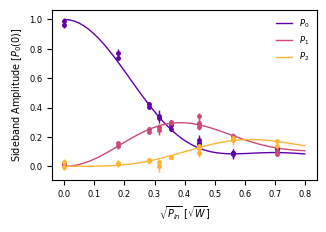

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8.4/2.54, 6/2.54))

plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 7,
    "axes.labelsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "figure.titlesize": 7,
    "lines.linewidth": 1,
    "lines.markersize": 5,
    "legend.frameon": False
})

#plot sideband powers
plt.errorbar(xvals, yvals[0], yerr = yerrs[0] , color = '#6200aa', fmt='.')
plt.errorbar(xvals, yvals[1], yerr = yerrs[1] , color = '#cc4a74', fmt='.')
plt.errorbar(xvals, yvals[2], yerr = yerrs[2] , color = '#fcb431',  fmt='.')

#plot the fitted curves
plt.plot(root_power, plist.T[0], '#6200aa', label = '$P_0$')
plt.plot(root_power, plist.T[1],'#cc4a74',label = '$P_1$')
plt.plot(root_power, plist.T[2],'#fcb431',label = '$P_2$')

plt.legend(frameon = False)
plt.xlabel('$\sqrt{P_{in}}~[\sqrt{W}]$')
plt.ylabel('Sideband Amplitude [$P_{0}(0)$]')

plt.tight_layout()
plt.savefig(savedir+"bessel.png", dpi=300, bbox_inches='tight')
plt.show()

## Supplementary
### FIGURE SI 6A


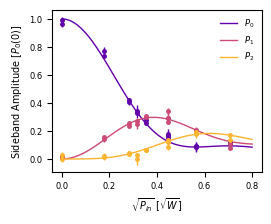

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7/2.54, 5.8/2.54))

plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 7,
    "axes.labelsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "figure.titlesize": 7,
    "lines.linewidth": 1,
    "lines.markersize": 5,
    "legend.frameon": False
})

#plot sideband powers
plt.errorbar(xvals, yvals[0], yerr = yerrs[0] , color = '#6200aa', fmt='.')
plt.errorbar(xvals, yvals[1], yerr = yerrs[1] , color = '#cc4a74', fmt='.')
plt.errorbar(xvals, yvals[2], yerr = yerrs[2] , color = '#fcb431',  fmt='.')

#plot the fitted curves
plt.plot(root_power, plist.T[0], '#6200aa', label = '$P_0$')
plt.plot(root_power, plist.T[1],'#cc4a74',label = '$P_1$')
plt.plot(root_power, plist.T[2],'#fcb431',label = '$P_2$')

plt.legend(frameon = False)
plt.xlabel('$\sqrt{P_{in}}~[\sqrt{W}]$')
plt.ylabel('Sideband Amplitude [$P_{0}(0)$]')

plt.tight_layout()
plt.savefig(savedir+"bessel_si.png", dpi=300, bbox_inches='tight')
plt.show()

### FIGURE SI 6B

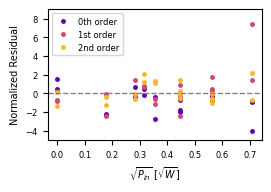

reduced_chi2: 2.56
reduced_chi2: 1.64
reduced_chi2: 1.38


In [48]:

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7/2.54, 5/2.54))

plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 7,
    "axes.labelsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "figure.titlesize": 7,
    "lines.linewidth": 1,
    "lines.markersize": 5,
    "legend.frameon": True
})


# Calculate all residuals grouped by sideband
residuals_array = result.fun
num_orders = 3
num_points = len(xvals)

# Reshape residuals: shape (3, N)
residuals_matrix = residuals_array.reshape((num_points, num_orders)).T

# Define color and label for each order
colors = ['#6200aa', '#cc4a74', '#fcb431']
labels = ['0th order', '1st order', '2nd order']

# Plot

for order in range(num_orders):
    plt.plot(xvals, residuals_matrix[order], '.', color=colors[order], label=labels[order])

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('$\sqrt{P_{in}}~[\sqrt{W}]$')

plt.ylabel('Normalized Residual')
plt.ylim(-5,9)

plt.legend()
plt.savefig(savedir+"bessel_si_residual.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

residuals = result.fun
print(f"reduced_chi2: {np.sum(residuals**2) / (len(residuals) - len(result.x)):.2f}")
residuals = np.delete(residuals, np.argmax(np.abs(residuals))) 
print(f"reduced_chi2: {np.sum(residuals**2) / (len(residuals) - len(result.x)):.2f}")
residuals = np.delete(residuals, np.argmax(np.abs(residuals))) 
print(f"reduced_chi2: {np.sum(residuals**2) / (len(residuals) - len(result.x)):.2f}")


### FIGURE SI 4

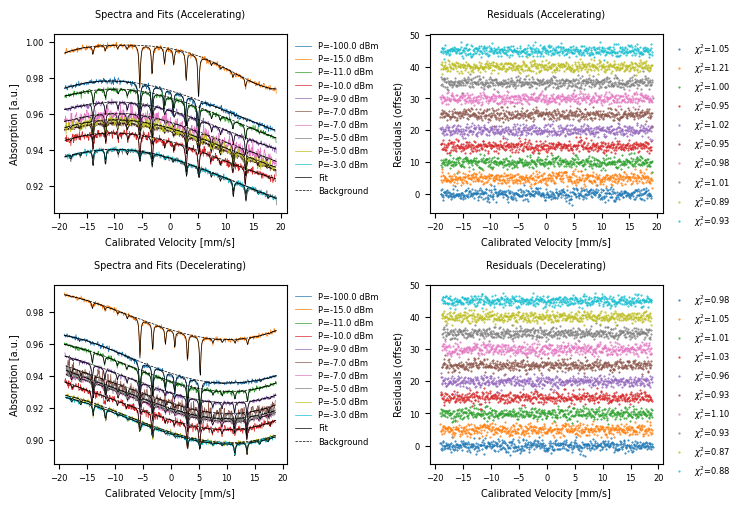

In [21]:
results_df = pd.read_pickle('analysis_16mms.pkl')
fitfunction = lorentzian18poly5
savedir = 'C:\\Users\\magrini\\Dropbox\\0 - stanford\\paper_saw\\figures\\'

plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 7,
    "axes.labelsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "figure.titlesize": 7,
    "lines.linewidth": 0.5,
    "lines.markersize": 1,
    "legend.frameon": False
})

fig, axes = plt.subplots(2, 2, figsize=(19/2.54, 13/2.54))  # 2 rows: one for left, one for right

for idx, side in enumerate(['left', 'right']):
    df = results_df[results_df['side'] == side]

    motion_label = "Accelerating" if side == "left" else "Decelerating"
    ax0 = axes[idx, 0]
    ax1 = axes[idx, 1]

    ax0.set_title(f"Spectra and Fits ({motion_label})", pad=12)
    ax1.set_title(f"Residuals ({motion_label})", pad=12)

    handles_spectra = []
    labels_spectra = []
    handles_res = []
    labels_res = []

    for i, row in enumerate(df.itertuples(index=True)):
        cal = row.calibration_fit
        real_x = poly1([-cal[0]/cal[1],1/cal[1]], row.x)

        h1, = ax0.plot(real_x, row.y, label=f"P={row.power} dBm")
        handles_spectra.append(h1)
        labels_spectra.append(f"P={row.power} dBm")

        if i == 0:
            h2, = ax0.plot(real_x, fitfunction(row.fitparams, row.x), 'k', label='Fit')
            h3, = ax0.plot(real_x, poly5(row.bg_params, row.x), 'k--', label='Background')
        else:
            ax0.plot(real_x, fitfunction(row.fitparams, row.x), 'k')
            ax0.plot(real_x, poly5(row.bg_params, row.x), 'k--')

        h4, = ax1.plot(real_x, row.norm_residuals + 5*i, '.', label=f"$\chi^2_r$={row.reduced_chi2:.2f}")
        handles_res.append(h4)
        labels_res.append(f"$\chi^2_r$={row.reduced_chi2:.2f}")

    handles_spectra.extend([h2, h3])
    labels_spectra.extend(["Fit", "Background"])

    ax0.set_xlabel("Calibrated Velocity [mm/s]")
    ax0.set_ylabel("Absorption [a.u.]")
    ax1.set_xlabel("Calibrated Velocity [mm/s]")
    ax1.set_ylabel("Residuals (offset)")

    ax0.legend(handles=handles_spectra, labels=labels_spectra, loc='upper left', bbox_to_anchor=(1, 1))
    ax1.legend(handles=handles_res, labels=labels_res, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.4)

# Save once
fig.savefig(savedir+"spectal_fitting.png", dpi=300, bbox_inches='tight')
plt.show()


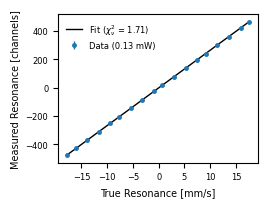

In [254]:
results_df = pd.read_pickle('analysis_16mms.pkl')
savedir = 'C:\\Users\\magrini\\Dropbox\\0 - stanford\\paper_saw\\figures\\'


plt.rcParams.update({
    "font.size": 6,
    "axes.titlesize": 7,
    "axes.labelsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "figure.titlesize": 7,
    "lines.linewidth": 1,
    "lines.markersize": 5,
    "legend.frameon": False
})



side = 'left'
power = -9
power_mW = 10**(power / 10)  # ≈ 0.13 mW

df_single = results_df[(results_df['side'] == side) & (results_df['power'] == power)]

fig, ax = plt.subplots(1, 1, figsize=(8/2.54, 6.1/2.54))

# ----------- Subplot 1: Calibration Fit -----------
scale = 512 / 16  # [channels → mm/s]

pcal = df_single['calibration_fit'].values[0] * scale
x = df_single['resonances_true'].values[0]                    # [mm/s]
y = df_single['resonances_fit'].values[0] * scale             # [mm/s]
dy = np.sqrt((df_single['resonances_fit_error'].values[0] * scale)**2 + (1 / 12))  # [mm/s]

# Chi²
norm_residuals = (y - poly1(pcal, x)) / dy
reduced_chi2 = np.sum(norm_residuals ** 2) / (len(y) - len(pcal))
chi_label = rf"Fit ($\chi^2_\nu$ = {reduced_chi2:.2f})"

# Plot
ax.errorbar(x, y, yerr=dy, fmt='.',label=f'Data ({power_mW:.2f} mW)')
ax.plot(x, poly1(pcal, x), label=chi_label, color='black')

ax.set_xlabel("True Resonance [mm/s]")
ax.set_ylabel("Measured Resonance [channels]")
ax.legend()


# ----------- Layout and Save -----------
plt.tight_layout(pad=4.0)
plt.subplots_adjust(top=0.9, wspace=0.3)

fig.savefig(savedir+"velocity_calibration.png", dpi=300, bbox_inches='tight')
plt.show()


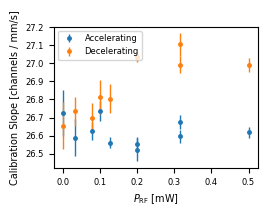

In [251]:
results_df = pd.read_pickle('analysis_16mms.pkl')
savedir = 'C:\\Users\\magrini\\Dropbox\\0 - stanford\\paper_saw\\figures\\'


plt.rcParams.update({
    "font.size": 6,
    "axes.titlesize": 7,
    "axes.labelsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "figure.titlesize": 7,
    "lines.linewidth": 1,
    "lines.markersize": 5,
    "legend.frameon": False
})



side = 'left'
power = -9
power_mW = 10**(power / 10)  # ≈ 0.13 mW

df_single = results_df[(results_df['side'] == side) & (results_df['power'] == power)]

fig, ax = plt.subplots(1, 1, figsize=(8/2.54, 6/2.54))

# ----------- Subplot 2: Calibration Slope vs Power -----------
for side in ['left', 'right']:

    motion_label = "Accelerating" if side == "left" else "Decelerating"
    
    df_side = results_df[results_df['side'] == side]
    power = 10 ** (df_side['power'] / 10)  # linear amplitude

    slope = np.array(df_side['calibration_fit'].tolist())[:, 1] * scale  # mm/s / mm/s = unitless
    slope_err = np.array(df_side['calibration_fit_error'].tolist())[:, 1] * scale

    ax.errorbar(power, slope, yerr=slope_err, fmt='.', label=f'{motion_label}')

ax.set_xlabel(r"$P_{\mathrm{RF}}$ [mW]")
ax.set_ylabel("Calibration Slope [channels / mm/s]")
ax.legend(frameon =True, loc = 'upper left')

# ----------- Layout and Save -----------
plt.tight_layout(pad=4.0)
plt.subplots_adjust(top=0.9, wspace=0.3)

fig.savefig(savedir+"velocity_calibration_residuals.png", dpi=300, bbox_inches='tight')
plt.show()


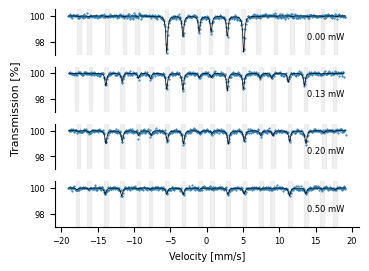

In [46]:
plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 7,
    "axes.labelsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "figure.titlesize": 7,
    "lines.linewidth": 0.5,
    "lines.markersize": 1,
    "legend.frameon": False
})




side = 'left'
powers_to_plot = [-100, -9, -7, -3]
#powers_to_plot = [-3, -7, -9, -100]
n = len(powers_to_plot)

fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(9/2.54, 7/2.54), sharex=True)


df_single = results_df[(results_df['side'] == side) & (results_df['power'] == -7)]
cal = df_single['calibration_fit'].values[0]


for i, (power, ax) in enumerate(zip(powers_to_plot, axes)):
    df_single = results_df[(results_df['side'] == side) & (results_df['power'] == power)]
    if df_single.empty:
        continue

    
    bgparams = df_single['bg_params'].values[0]
    fitparams = df_single['fitparams'].values[0]

    x = df_single['x'].values[0]
   
    x_real = poly1([-cal[0]/cal[1], 1/cal[1]], x)

    y = df_single['y'].values[0]
    y_norm = y / poly5(bgparams, x) * 100
    y_fit_norm = lorentzian18poly5(fitparams, x) / poly5(bgparams, x) * 100

    ax.plot(x_real, y_norm, '.')
    ax.plot(x_real, y_fit_norm, '-', color='black')

    integral_bw = 0.5
    cal = df_single['calibration_fit'].values[0]
    resonances = poly1([-cal[0]/cal[1],1/cal[1]],df_single['resonances_fit'].values[0])
    for xc in resonances:
        ax.axvspan(xc - integral_bw/2, xc + integral_bw/2, color='gray', alpha=0.1)
    
    ax.set_ylim(97, 100.5)

    # Minimal power label
    ax.text(0.95, 0.5, f"{10**(power/10):.2f} mW", transform=ax.transAxes,
            ha='right', va='top', fontsize = 6)

    # Hide ticks and spines except for bottom
    if i < n - 1:
        ax.tick_params(labelbottom=False,bottom=False, left=True)
        ax.spines['bottom'].set_visible(False)
    else:
        ax.set_xlabel("Velocity [mm/s]")
    
    ax.set_yticks([98, 100])
    # Clean top/right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.subplots_adjust(left=0.1, bottom=0.08, right=0.98, top=0.98, hspace=0)
fig.text(-0.02, 0.6, 'Transmission [%]', va='center', rotation='vertical')


plt.tight_layout()
plt.savefig(savedir+"normalized_spectra.png", dpi=300, bbox_inches='tight')
plt.show()
